In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

from datasets import load_GPCA_and_MAPPIT_data, load_y2h_pairwise_test

In [2]:
# the ipython matplotlib inline display overrides the rcParams
# that used to be called on the pyplot import but now seems like
# it's called on the first use of inline figures or something 
# problem is in ipython: https://github.com/ipython/ipython/issues/10383
# should be fixed soon: https://github.com/ipython/matplotlib-inline/pull/14
plt.show()
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
gpca = load_GPCA_and_MAPPIT_data(remove_homodimers=True)
y2h = load_y2h_pairwise_test(remove_homodimers=True)
gi_pcc_sources = ['GI_PSN_PCC_gt_0.2',
                   'GI_PSN_PCC_gt_0.3',
                   'GI_PSN_PCC_gt_0.5']
gpca = gpca.loc[(gpca['experiment_ID'] == 'Sv01') &
                gpca['source_dataset'].isin(['scPRS-v2', 'scRRS-v2'] + gi_pcc_sources), :]
y2h = y2h.loc[y2h['source_dataset'].isin(['scPRS-v2', 'scRRS-v2'] + gi_pcc_sources), :]
gpca = gpca.rename(columns={'result_at_0_RRS': 'result'})

In [4]:
def std_err_proportion(pos, neg):
    f = pos / (pos + neg)
    return np.sqrt((f * (1. - f)) / (pos + neg))


estimate = []
estimate_err = []
for df in (y2h, gpca):
    prs_pos = ((df['source_dataset'] == 'scPRS-v2') & (df['result'] == True)).sum()
    prs_neg = ((df['source_dataset'] == 'scPRS-v2') & (df['result'] == False)).sum()
    prs_frac = prs_pos / (prs_pos + prs_neg)
    rrs_pos = ((df['source_dataset'] == 'scRRS-v2') & (df['result'] == True)).sum()
    rrs_neg = ((df['source_dataset'] == 'scRRS-v2') & (df['result'] == False)).sum()
    rrs_frac = rrs_pos / (rrs_pos + rrs_neg)
    prs_err = std_err_proportion(prs_pos, prs_neg)
    rrs_err = std_err_proportion(rrs_pos, rrs_neg)
    for pcc_min in ['0.2', '0.3', '0.5']:
        p = ((df['source_dataset'] == 'GI_PSN_PCC_gt_' + pcc_min) & (df['result'] == True)).sum()
        n = ((df['source_dataset'] == 'GI_PSN_PCC_gt_' + pcc_min) & (df['result'] == False)).sum()
        err = std_err_proportion(p, n)
        f_estimate = ((p / (p + n)) - rrs_frac) / (prs_frac - rrs_frac)
        estimate.append(f_estimate)
        # ignore the RRS uncertainty contribution since it has some cancelling out effect
        # from being in both the numerator and denominator
        estimate_err.append(np.sqrt((err / (p / (p + n))) ** 2 +
                                    (prs_err / prs_frac) ** 2)
                            * f_estimate)

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_14786/1901001803.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


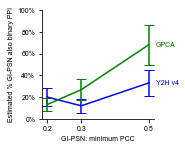

In [5]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
color_gpca = 'green'
color_y2h = 'blue'
ax.errorbar(x=[0.2, 0.3, 0.5],
             y=estimate[:3],
             yerr=estimate_err[:3],
             #fmt='none',
             color=color_y2h,
             capsize=5)
ax.errorbar(x=[0.2, 0.3, 0.5],
             y=estimate[3:],
             yerr=estimate_err[3:],
             #fmt='none',
             color=color_gpca,
             capsize=5)
ax.text(0.52, estimate[-1], 'GPCA', va='center', ha='left', color=color_gpca)
ax.text(0.52, estimate[2], 'Y2H v4', va='center', ha='left', color=color_y2h)
ax.set_ylabel('Estimated % GI-PSN also binary PPI')
ax.set_ylim(0, 1.)
ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
ax.set_xticks([0.2, 0.3, 0.5])
#ax.set_xticklabels(['0.2', '0.3', '0.5'])
ax.set_xlabel('GI-PSN: minimum PCC')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.savefig('../figures/estimated_binary_ppi_content_GI-PSN.pdf',
            bbox_inches='tight')